In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from scipy import stats
from sklearn import metrics
from datetime import datetime

In [3]:
import statsmodels.api as sm
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

In [4]:
f = pd.read_csv('C:\\PRSA_data.csv')
df = pd.DataFrame(f)

In [5]:
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [6]:
df.columns = ['number', 'year', 'month', 'day', 'hour', 'pm25', 'dewp', 'temp', 'pres', 'cbwd', 'cws', 'cs', 'cr']

In [7]:
df['date'] = pd.to_datetime(df[['year','month','day','hour']])

In [8]:
# Setting DateTime index
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d-%h')
df.set_index('date', inplace=True)

# Functions

In [9]:
def seasonal_mean(df, season_var, con_var):
    """
    Generates the mean of the seasonal period of choice, plus the upper and lower Confidence Intervals
    
    df: DataFrame containing the data
    season_var: Seasonal categorical variable - day/hour/month
    con_var: Continuous variable providing the "mean" reading of interest
    n_sample: Number of samples for each mean reading
    
    """
    
    mean_dict = dict(df.groupby(season_var)[con_var].mean())
    
    n = df.groupby(season_var)[con_var].count().mean()
    
    upper_dict = dict(df.groupby(season_var)[con_var].mean() + 
                      1.96*(df.groupby(season_var)[con_var].std()/((n-1)**0.5)))
    
    lower_dict = dict(df.groupby(season_var)[con_var].mean() - 
                      1.96*(df.groupby(season_var)[con_var].std()/((n-1)**0.5)))
    
    mean_df = pd.DataFrame([mean_dict, upper_dict, lower_dict]).transpose()
    mean_df.columns = ['mean', 'upper_CI', 'lower_CI']
    
    return mean_df


In [10]:
def adf_statistics(series):
    """
    Function to output Augmented Dickey-Fuller test for stationarity
    
    series: Time series of interest
    """
    result = adfuller(series.values)
    
    print('ADF Statistic: %.4f' % result[0])
    print('p-value: %.4f' % result[1])
    
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.4f' % (key, value))
    if result[1] < 0.0500:
        print("Null hypothesis of non-stationarity is rejected")
    else:
        print("Null hypothesis of non-stationarity is NOT rejected")


In [11]:
# Function for sin-cosine cyclic transformation
def cyclic_transform(column):
    max_val = column.max()
    sine = [np.sin((2 * np.pi * i)/max_val) for i in list(column)]
    cosine = [np.cos((2 * np.pi * i)/max_val) for i in list(column)]
    return sine, cosine


# Initial EDA of Target

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   number  43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm25    41757 non-null  float64
 6   dewp    43824 non-null  int64  
 7   temp    43824 non-null  float64
 8   pres    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  cws     43824 non-null  float64
 11  cs      43824 non-null  int64  
 12  cr      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.7+ MB


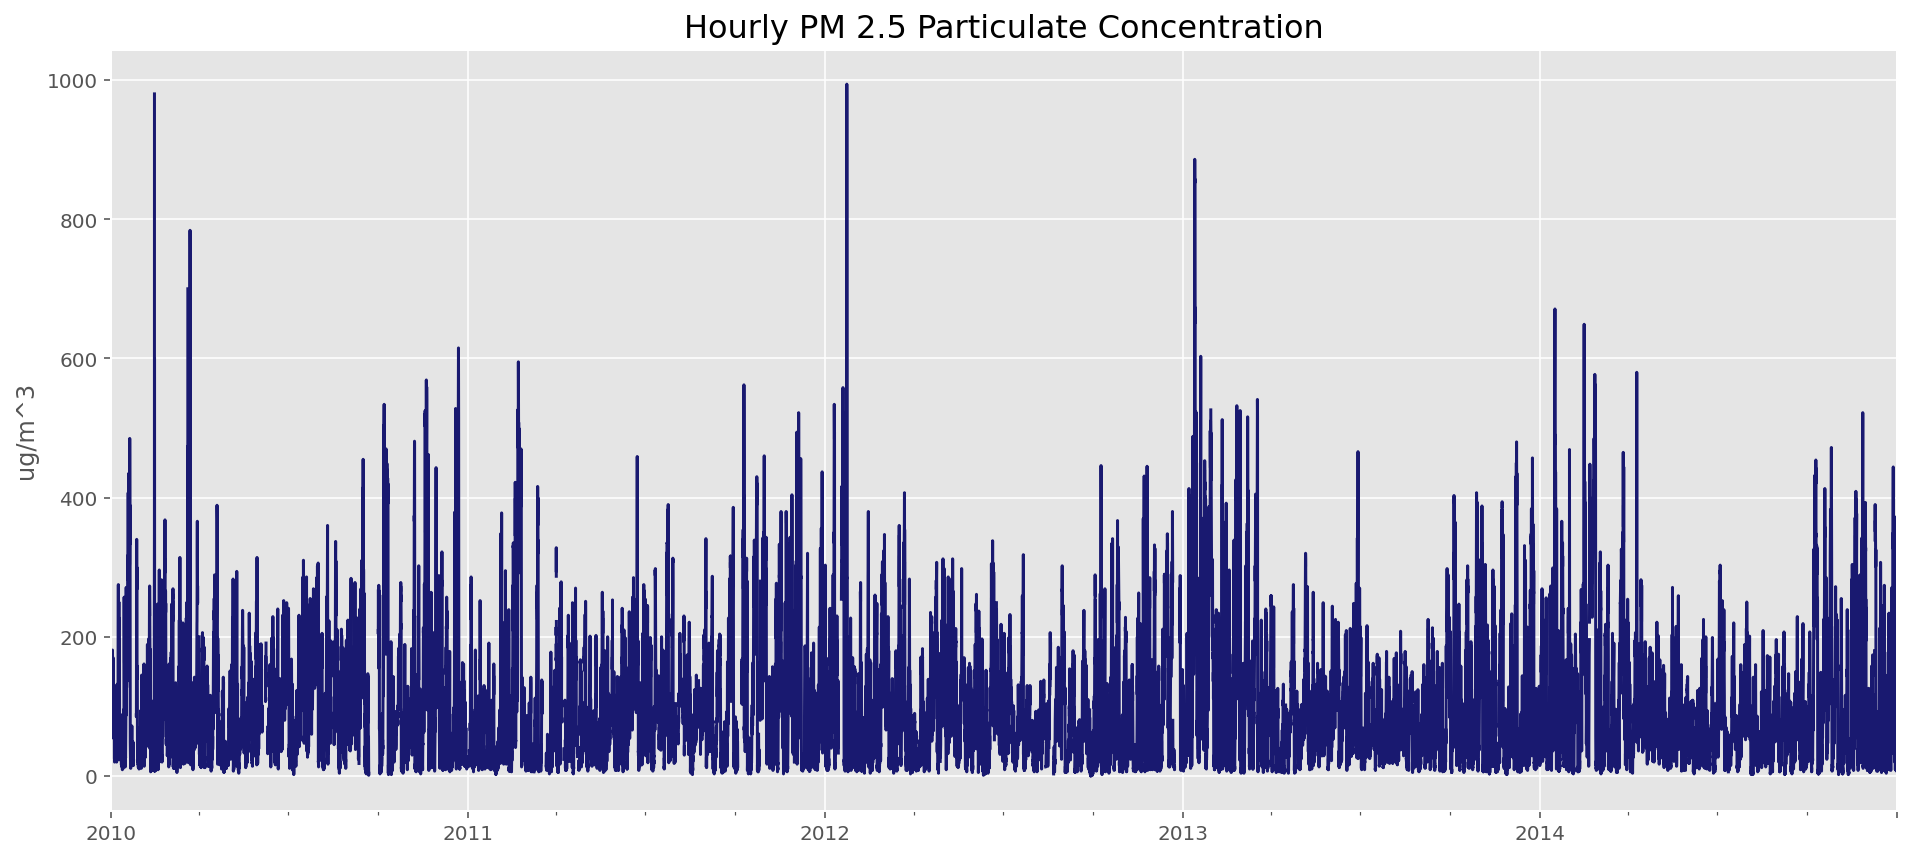

In [13]:
df['pm25'].plot(lw=1.5, color='midnightblue', figsize=(16, 7))
plt.title('Hourly PM 2.5 Particulate Concentration', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

In [14]:
df.describe()

,number,year,month,day,hour,pm25,dewp,temp,pres,cws,cs,cr
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


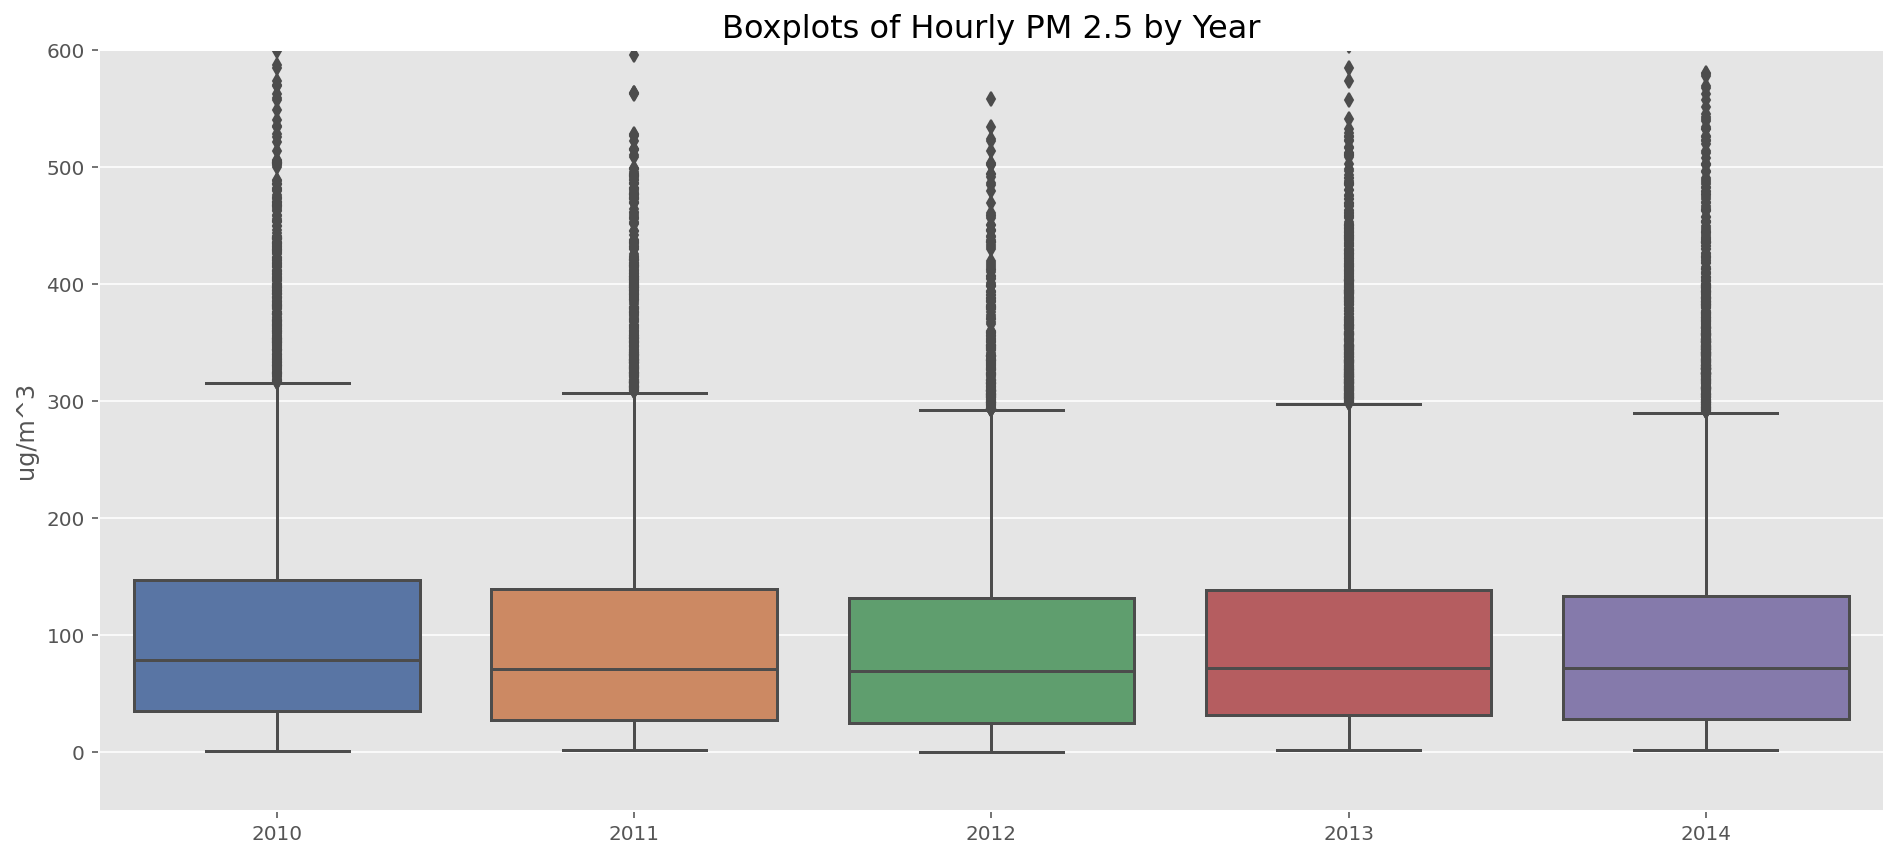

In [15]:
# Box-plots for 'PM 2.5' indicating no major trends in the distributions across the years
plt.figure(figsize=(16,7))

ax=sns.boxplot(x='year', y='pm25', data=df, orient='v', palette = sns.color_palette("deep", 5))
ax.set(ylim=(-50, 600))

plt.title('Boxplots of Hourly PM 2.5 by Year', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

### Weekends vs Weekdays

In [16]:
# Subsetting by weekends
we = df.loc[df.index.weekday >= 5]['pm25']

In [17]:
# Subsetting by weekdays
wd = df.loc[df.index.weekday < 5]['pm25']

In [18]:
we

date
2010-01-02 00:00:00    129.0
2010-01-02 01:00:00    148.0
2010-01-02 02:00:00    159.0
2010-01-02 03:00:00    181.0
2010-01-02 04:00:00    138.0
                       ...  
2014-12-28 19:00:00    110.0
2014-12-28 20:00:00    175.0
2014-12-28 21:00:00    293.0
2014-12-28 22:00:00    324.0
2014-12-28 23:00:00    341.0
Name: pm25, Length: 12528, dtype: float64

In [19]:
# 5.2% of the weekend values are NaN
we.isnull().sum()

645

In [20]:
wd

date
2010-01-01 00:00:00     NaN
2010-01-01 01:00:00     NaN
2010-01-01 02:00:00     NaN
2010-01-01 03:00:00     NaN
2010-01-01 04:00:00     NaN
                       ... 
2014-12-31 19:00:00     8.0
2014-12-31 20:00:00    10.0
2014-12-31 21:00:00    10.0
2014-12-31 22:00:00     8.0
2014-12-31 23:00:00    12.0
Name: pm25, Length: 31296, dtype: float64

In [21]:
# 4.5% of the weekday values are NaN
wd.isnull().sum()

1422

In [22]:
stats.ttest_ind(we, wd, equal_var=False, nan_policy='omit')

Ttest_indResult(statistic=4.6550959950843005, pvalue=3.2579698189315677e-06)

**t-test** of equality of means **rejects the null hypothesis** of no difference in the mean 'pm25' readings between weekends and weekdays.

### Seasonality in 'PM 2.5'

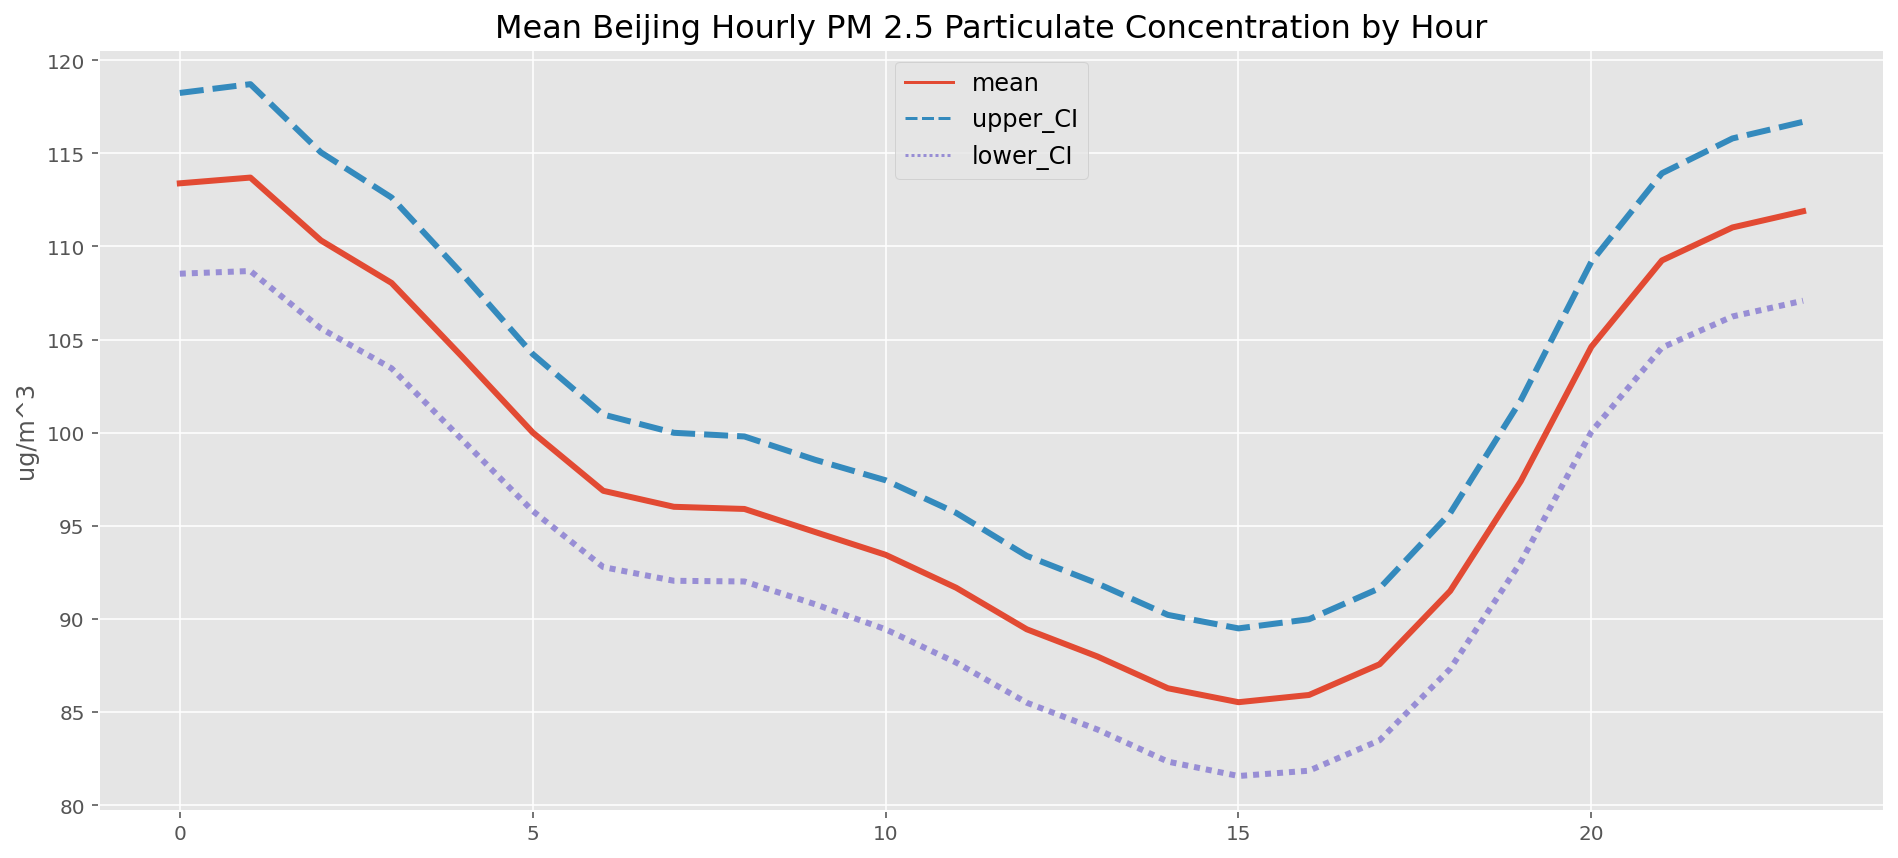

In [23]:
hour_avg = seasonal_mean(df, 'hour', 'pm25')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=hour_avg, ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Mean Beijing Hourly PM 2.5 Particulate Concentration by Hour', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

There is a general **downtrend** in the average hourly 'PM 2.5' between midnight and 15:00, and an **uptrend** between 15:00 and 23:00.

The **monthly average** 'PM 2.5' readings also exhibit seasonality. The readings tend to be low in the warmer months, and higher in the colder months, with pronounced peaks in the average **February and October** readings.

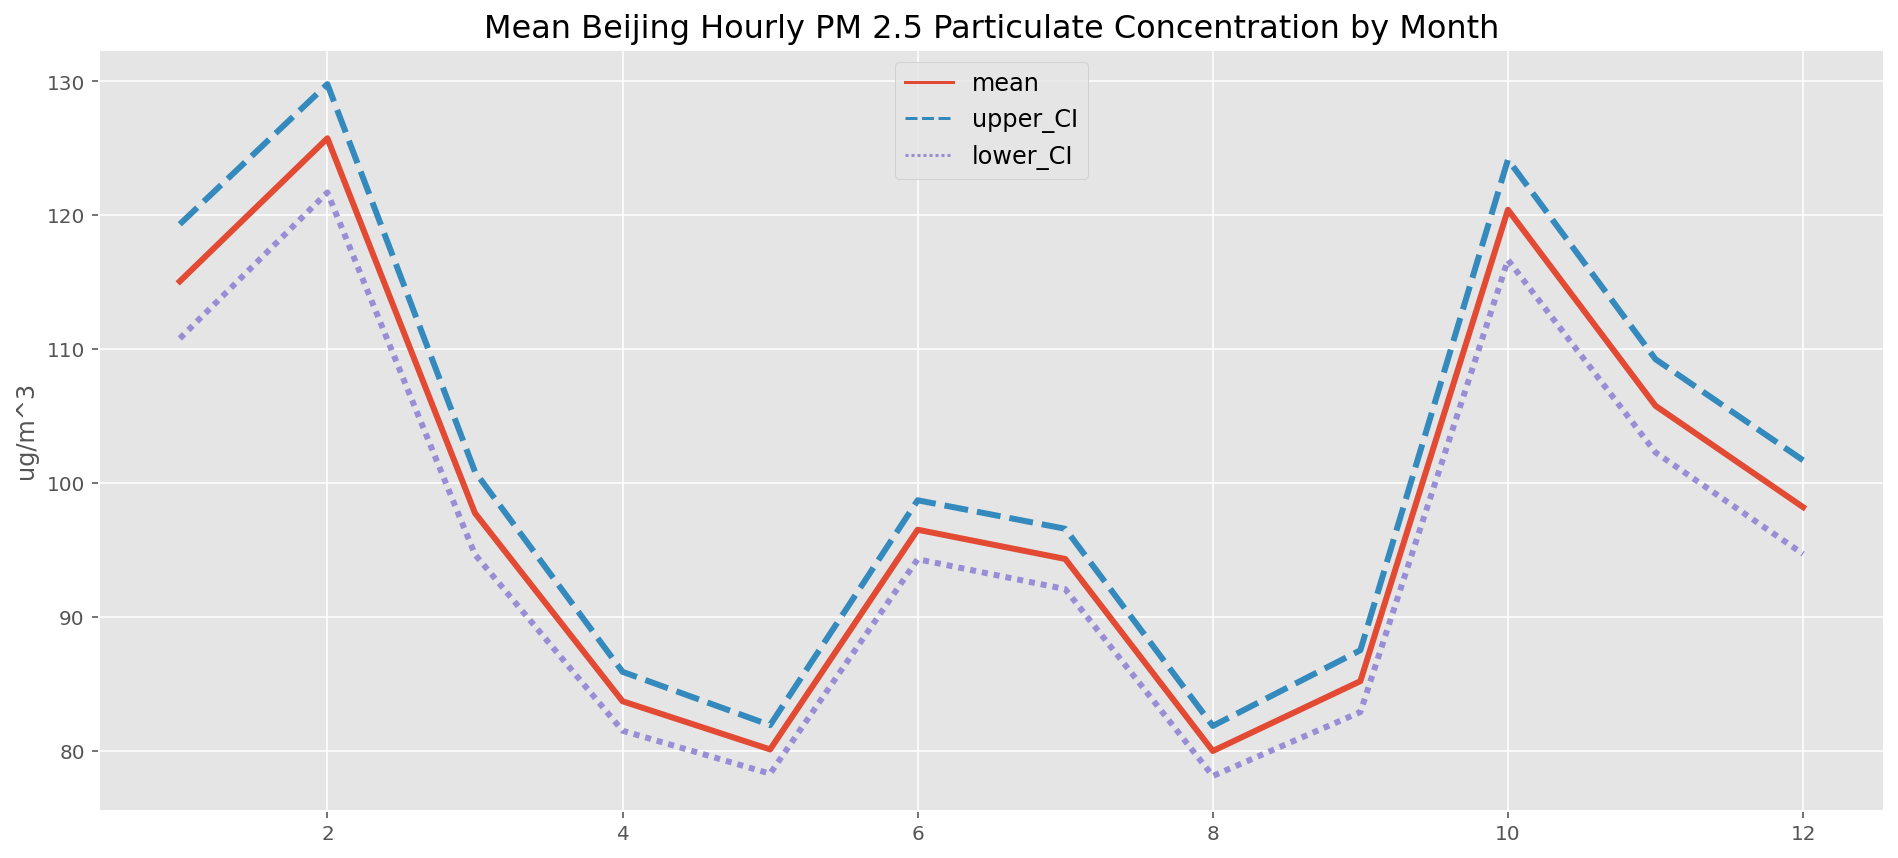

In [24]:
month_avg = seasonal_mean(df, 'month', 'pm25')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=month_avg, ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Mean Beijing Hourly PM 2.5 Particulate Concentration by Month', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

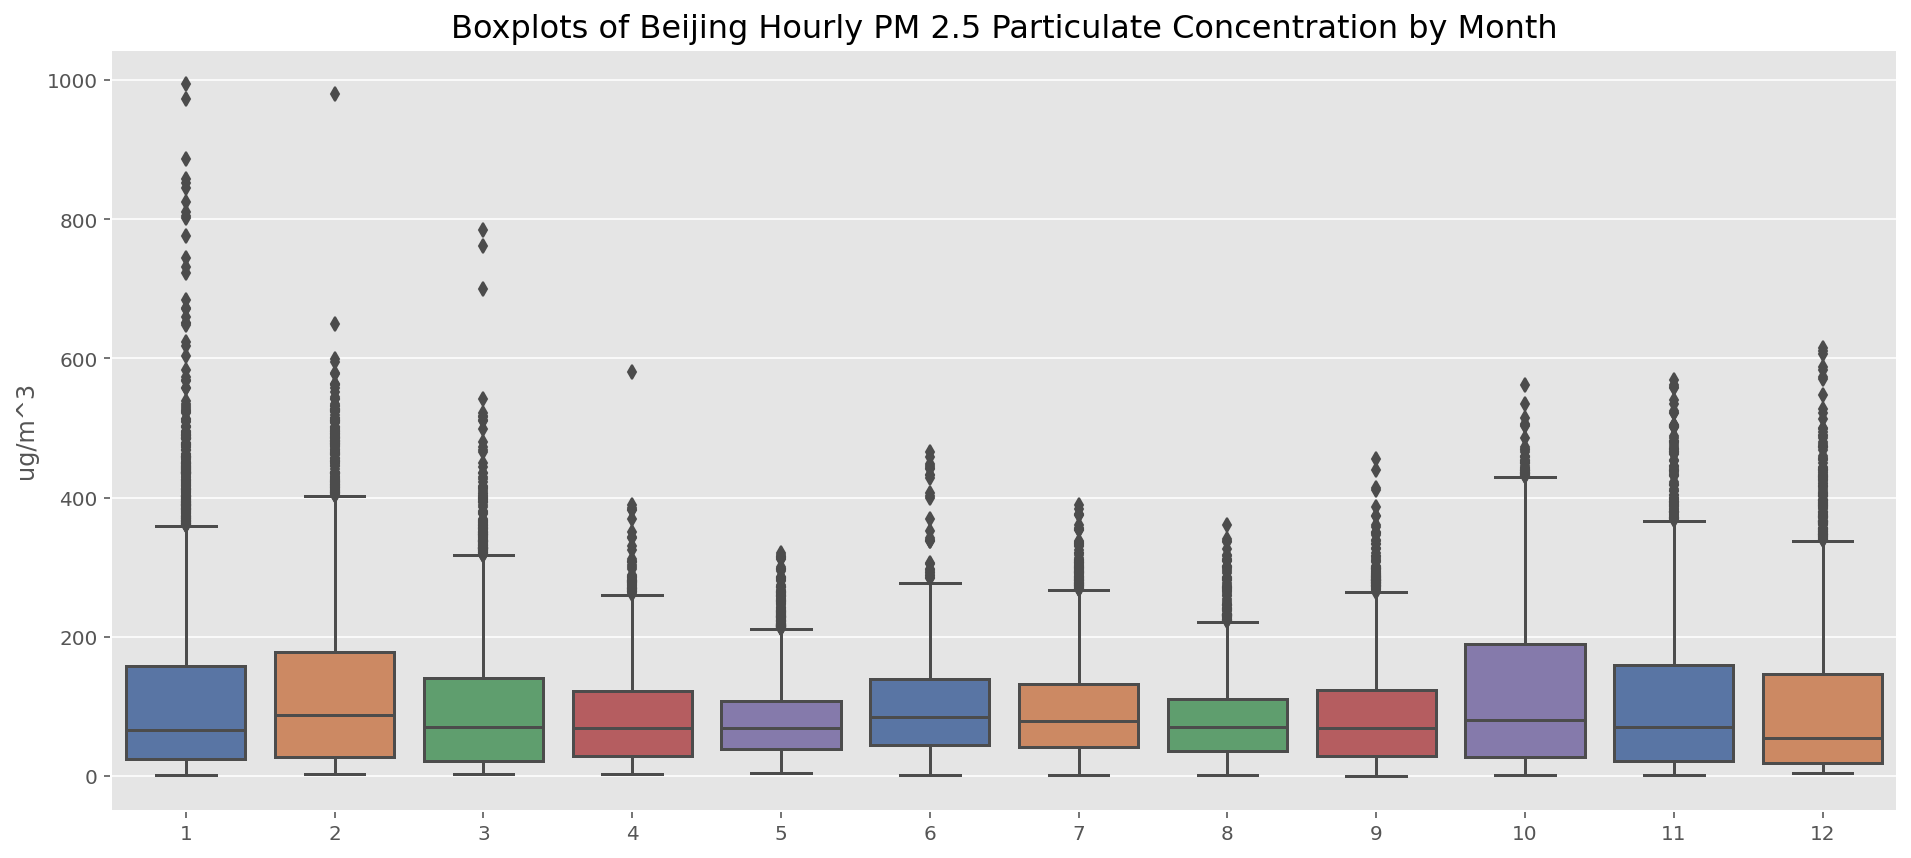

In [25]:
plt.figure(figsize=(16,7))

ax=sns.boxplot(x='month', y='pm25', data=df, orient='v', palette = sns.color_palette("deep", 5))

plt.title('Boxplots of Beijing Hourly PM 2.5 Particulate Concentration by Month', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

### Standardizing target variable

In [26]:
scaler = StandardScaler()

In [27]:
# Standardise the target data, and the output are two Numpy arrays
df['pm25_scaled'] = scaler.fit_transform(df[['pm25']]) 

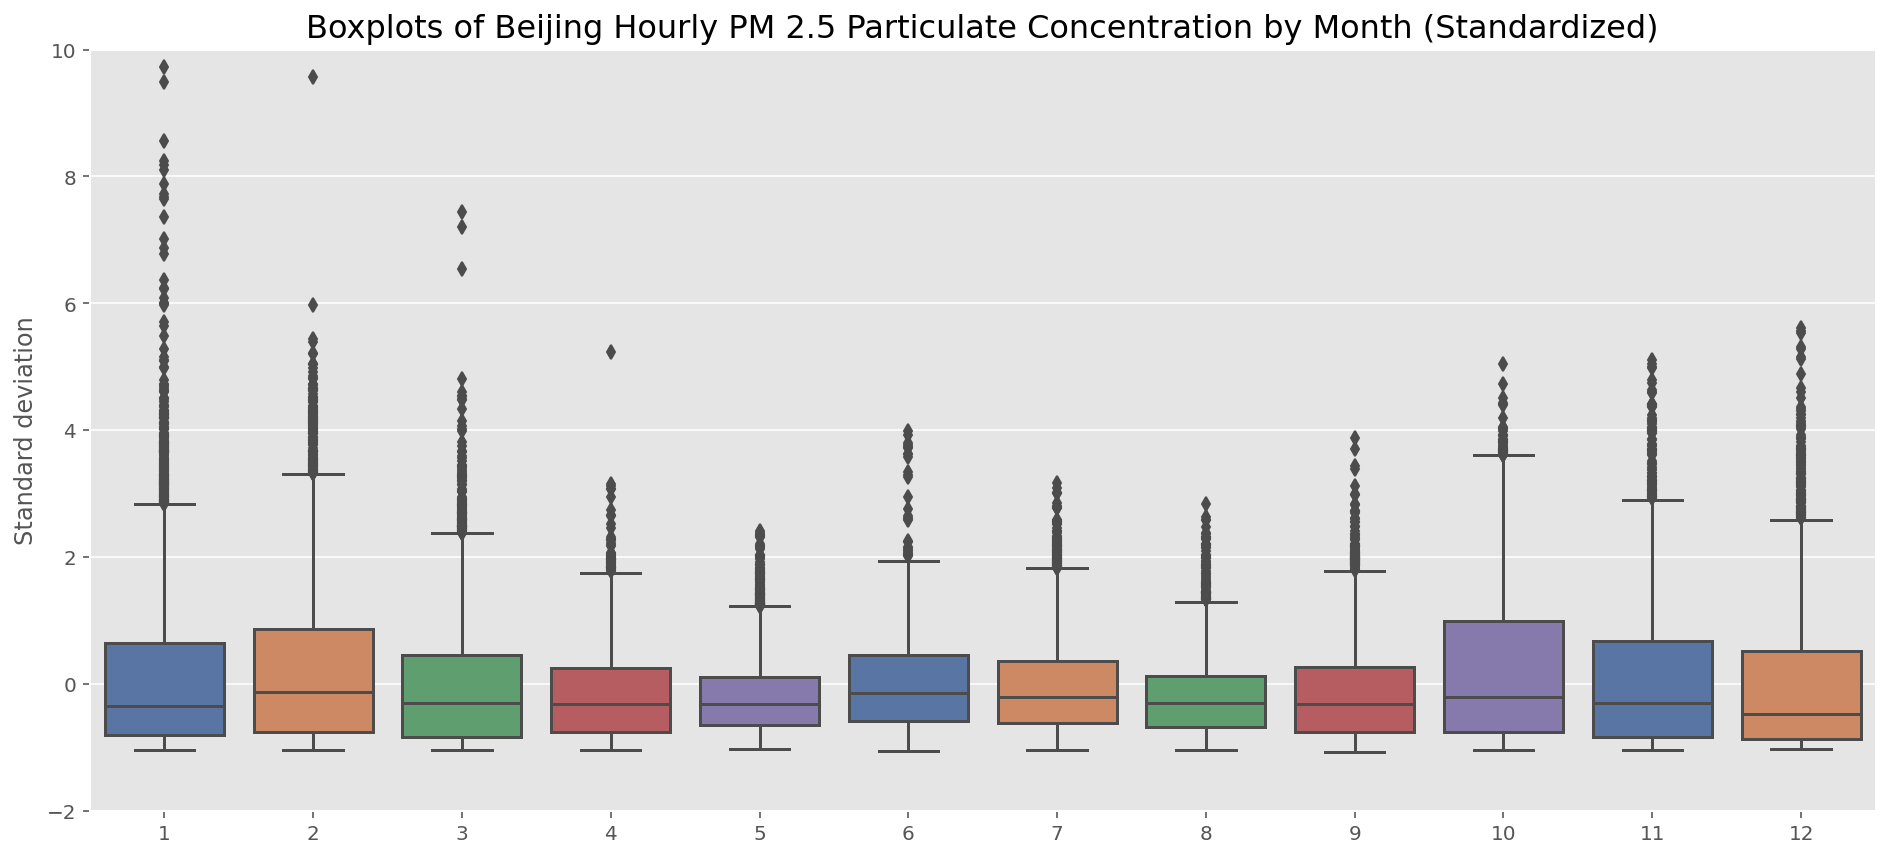

In [28]:
plt.figure(figsize=(16,7))

ax=sns.boxplot(x='month', y='pm25_scaled', data=df, orient='v', palette = sns.color_palette("deep", 5))
ax.set(ylim=(-2, 10))

plt.title('Boxplots of Beijing Hourly PM 2.5 Particulate Concentration by Month (Standardized)', fontsize=16)
plt.xlabel('')
plt.ylabel('Standard deviation', fontsize=12);

# Missing Values Imputation

In [29]:
df.isnull().sum()

number            0
year              0
month             0
day               0
hour              0
pm25           2067
dewp              0
temp              0
pres              0
cbwd              0
cws               0
cs                0
cr                0
pm25_scaled    2067
dtype: int64

It so happens that the **target variable** is the only one that has missing variables. Let's check where these **missing target variable values** are located...

In [30]:
# The very first day of the sample is missing the target variable. 
df.loc[(df.index.month==1) & (df.index.year==2010)].isnull().sum()

number          0
year            0
month           0
day             0
hour            0
pm25           91
dewp            0
temp            0
pres            0
cbwd            0
cws             0
cs              0
cr              0
pm25_scaled    91
dtype: int64

In [31]:
df.loc[df.index.year==2010].isnull().sum()

number           0
year             0
month            0
day              0
hour             0
pm25           669
dewp             0
temp             0
pres             0
cbwd             0
cws              0
cs               0
cr               0
pm25_scaled    669
dtype: int64

In [32]:
df.loc[df.index.year==2011].isnull().sum()

number           0
year             0
month            0
day              0
hour             0
pm25           728
dewp             0
temp             0
pres             0
cbwd             0
cws              0
cs               0
cr               0
pm25_scaled    728
dtype: int64

**Almost 5%** of the 'PM 2.5' observations are missing. Of these missing observations, **over two-thirds** are from the first two years, namely 2010 and 2011.

This weather-related data has both **intra-day and monthly seasonalities**, so a simple **linear interpolation** or **overall mean replacement** of the missing values is not appropriate.

Moreover, trying to fill in these missing values by using estimates of its relationship with the other variables, say through linear regression or tree-based models, is problematic because it would **generate target values that are automatically related to the explanatory variables**. 

I will proceed as follows: 
- **Delete** the first day's (1 January 2010) observations, which are entirely NaNs.
- **Interpolate inside** missing values when there are observations between 0:00 and 14:00 (inclusive) on each day, and then observations between 15:00 and 23:00 (inclusive) on each day. This **two-step procedure** respects the intra-day seasonality in the data.
- Fill in the remaining missing target values by the **median** of the available data grouped by month and hour.

In [33]:
# Deleting observations from 1 January 2010
df = df.iloc[24:]

Setting the **two time sections**, the first covering the hourly 'PM 2.5' **downtrend** (through 14:00) and the second the **uptrend** (starting 15:00).

In [34]:
# Intraday downtrend portion
df_down = df.iloc[df.index.indexer_between_time(start_time="00:00", end_time="14:00")]

In [35]:
# Intraday uptrend portion
df_up = df.iloc[df.index.indexer_between_time(start_time="15:00", end_time="23:00")]

In [36]:
df_down['pm25_imp'] = df_down.groupby(['year', 'month', 'day'])['pm25'].apply(lambda x: 
                                                                              x.interpolate(method='linear', 
                                                                                            limit_area='inside'))

C:\Users\Tan\AppData\Local\Temp/ipykernel_11500/1411708948.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_down['pm25_imp'] = df_down.groupby(['year', 'month', 'day'])['pm25'].apply(lambda x:


In [37]:
df_up['pm25_imp'] = df_up.groupby(['year', 'month', 'day'])['pm25'].apply(lambda x: 
                                                                          x.interpolate(method='linear', 
                                                                                        limit_area='inside'))

C:\Users\Tan\AppData\Local\Temp/ipykernel_11500/1357750374.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_up['pm25_imp'] = df_up.groupby(['year', 'month', 'day'])['pm25'].apply(lambda x:


In [38]:
df = pd.concat([df_down, df_up])
df.sort_index(inplace=True)

In [39]:
df[['pm25', 'pm25_imp']].describe()

,pm25,pm25_imp
count,41757.000000,41979.000000
mean,98.613215,98.697968
std,92.050387,92.147419
min,0.000000,0.000000
25%,29.000000,29.000000
50%,72.000000,72.000000
75%,137.000000,137.000000
max,994.000000,994.000000


Now, need to fill up the remaining missing values by the **hourly median** according to each **calendar month** for each year...

In [40]:
df['pm25_imp_10'] = df[df.index.year==2010].groupby(['month', 'hour'])['pm25_imp'].transform(lambda x:
                                                                                             x.fillna(x.median()))

In [41]:
df['pm25_imp_11'] = df[df.index.year==2011].groupby(['month', 'hour'])['pm25_imp'].transform(lambda x:
                                                                                             x.fillna(x.median()))

In [42]:
df['pm25_imp_12'] = df[df.index.year==2012].groupby(['month', 'hour'])['pm25_imp'].transform(lambda x:
                                                                                             x.fillna(x.median()))

In [43]:
df['pm25_imp_13'] = df[df.index.year==2013].groupby(['month', 'hour'])['pm25_imp'].transform(lambda x:
                                                                                             x.fillna(x.median()))

In [44]:
df['pm25_imp_14'] = df[df.index.year==2014].groupby(['month', 'hour'])['pm25_imp'].transform(lambda x:
                                                                                             x.fillna(x.median()))

In [45]:
df['pm25_imp_10'] = df['pm25_imp_10'].fillna(df.pm25_imp_11)

In [46]:
df['pm25_imp_10'] = df['pm25_imp_10'].fillna(df.pm25_imp_12)

In [47]:
df['pm25_imp_10'] = df['pm25_imp_10'].fillna(df.pm25_imp_13)

In [48]:
df['pm25_imp_10'] = df['pm25_imp_10'].fillna(df.pm25_imp_14)

In [49]:
df['pm25_imp'] = df['pm25_imp_10']

In [50]:
df[['pm25', 'pm25_imp']].describe()

,pm25,pm25_imp
count,41757.000000,43800.000000
mean,98.613215,98.032767
std,92.050387,90.519946
min,0.000000,0.000000
25%,29.000000,30.000000
50%,72.000000,74.000000
75%,137.000000,134.000000
max,994.000000,994.000000


In [51]:
df['pm25'] = df['pm25_imp']

In [52]:
df.drop(['pm25_imp', 'pm25_imp_10', 'pm25_imp_11', 'pm25_imp_12', 'pm25_imp_13', 
         'pm25_imp_14'], axis=1, inplace=True)

In [53]:
# Converting the float values to integer
df['pm25'] = df['pm25'].astype('int64')
df['temp'] = df['temp'].astype('int64')
df['pres'] = df['pres'].astype('int64')

# Seasonalities in the Data

There appears to be **daily and monthly seasonalities** in the data. 

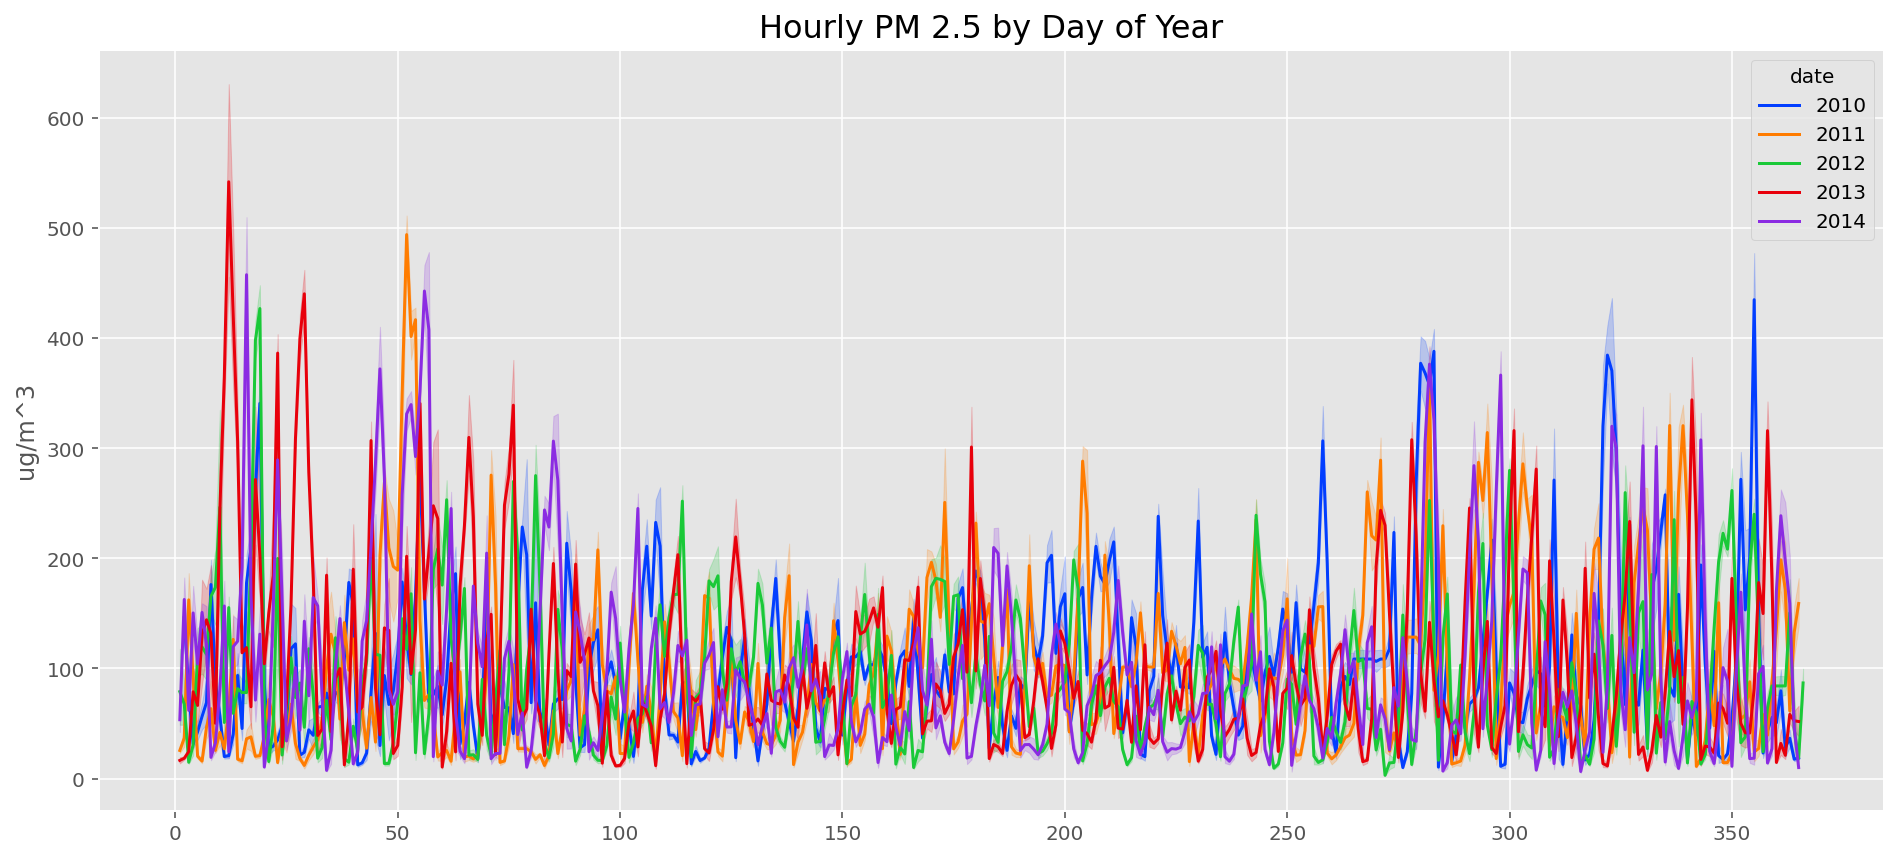

In [54]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(x = df.index.dayofyear, 
             y = df['pm25'], 
             hue = df.index.year,
             palette = sns.color_palette("bright", 5),
             ax = ax)

plt.xlabel('', fontsize=12)
plt.ylabel('ug/m^3', fontsize=12)
plt.title('Hourly PM 2.5 by Day of Year', fontsize=16);

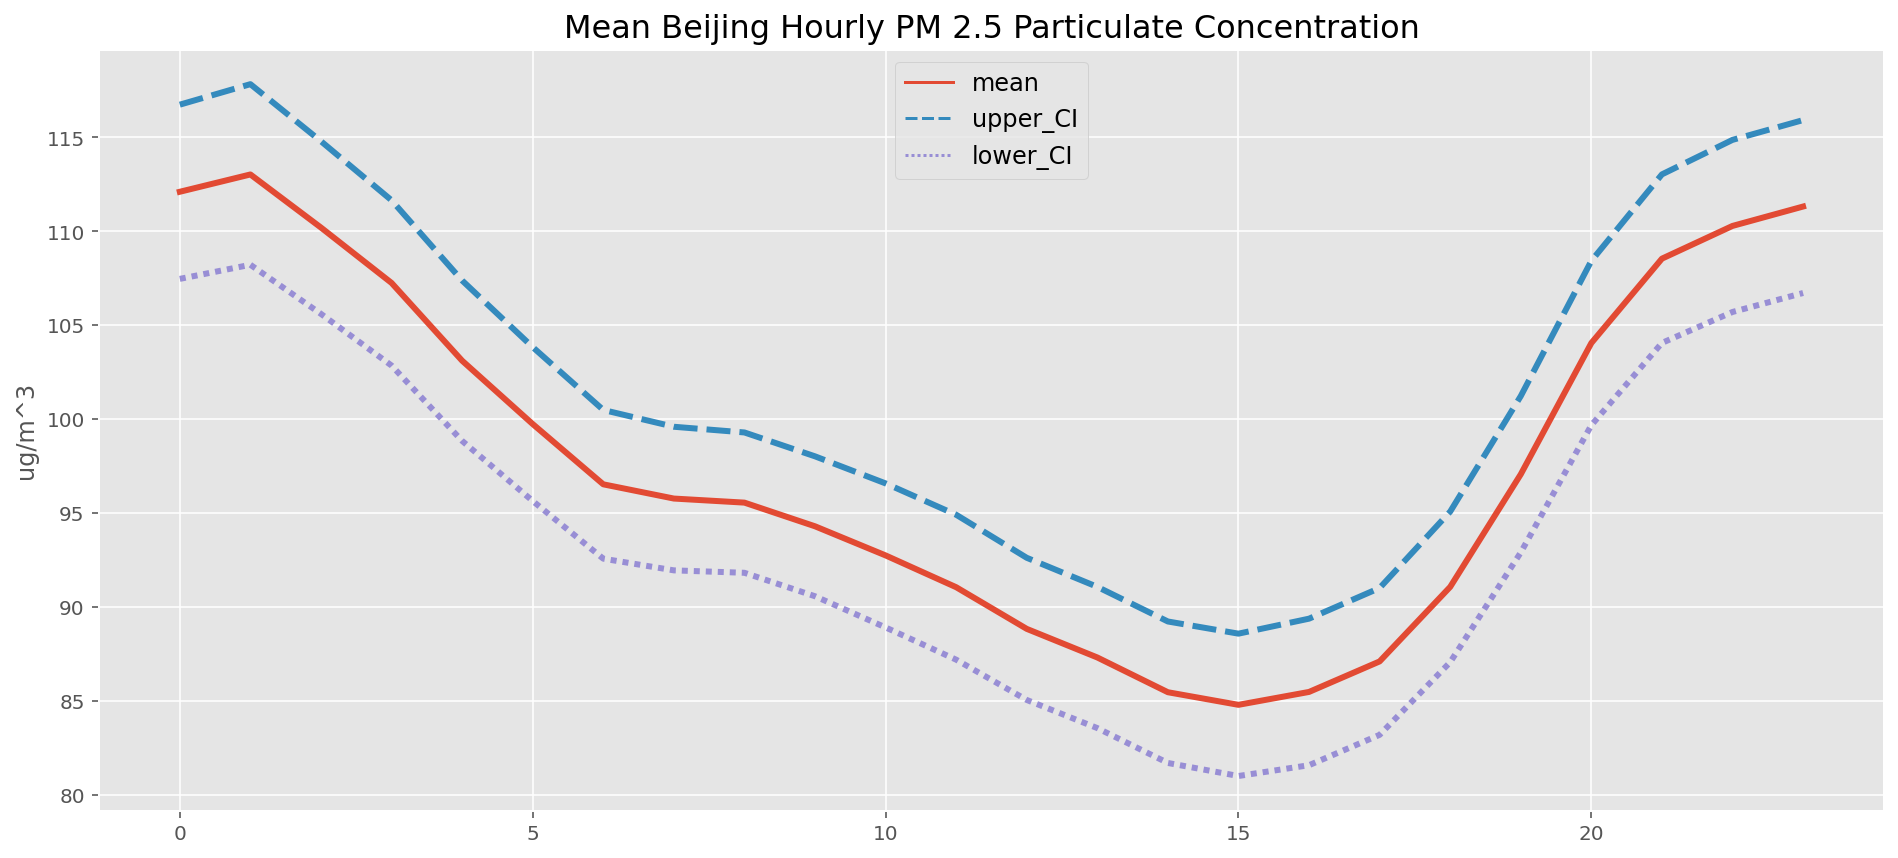

In [55]:
hour_avg = seasonal_mean(df, 'hour', 'pm25')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=hour_avg, ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Mean Beijing Hourly PM 2.5 Particulate Concentration', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

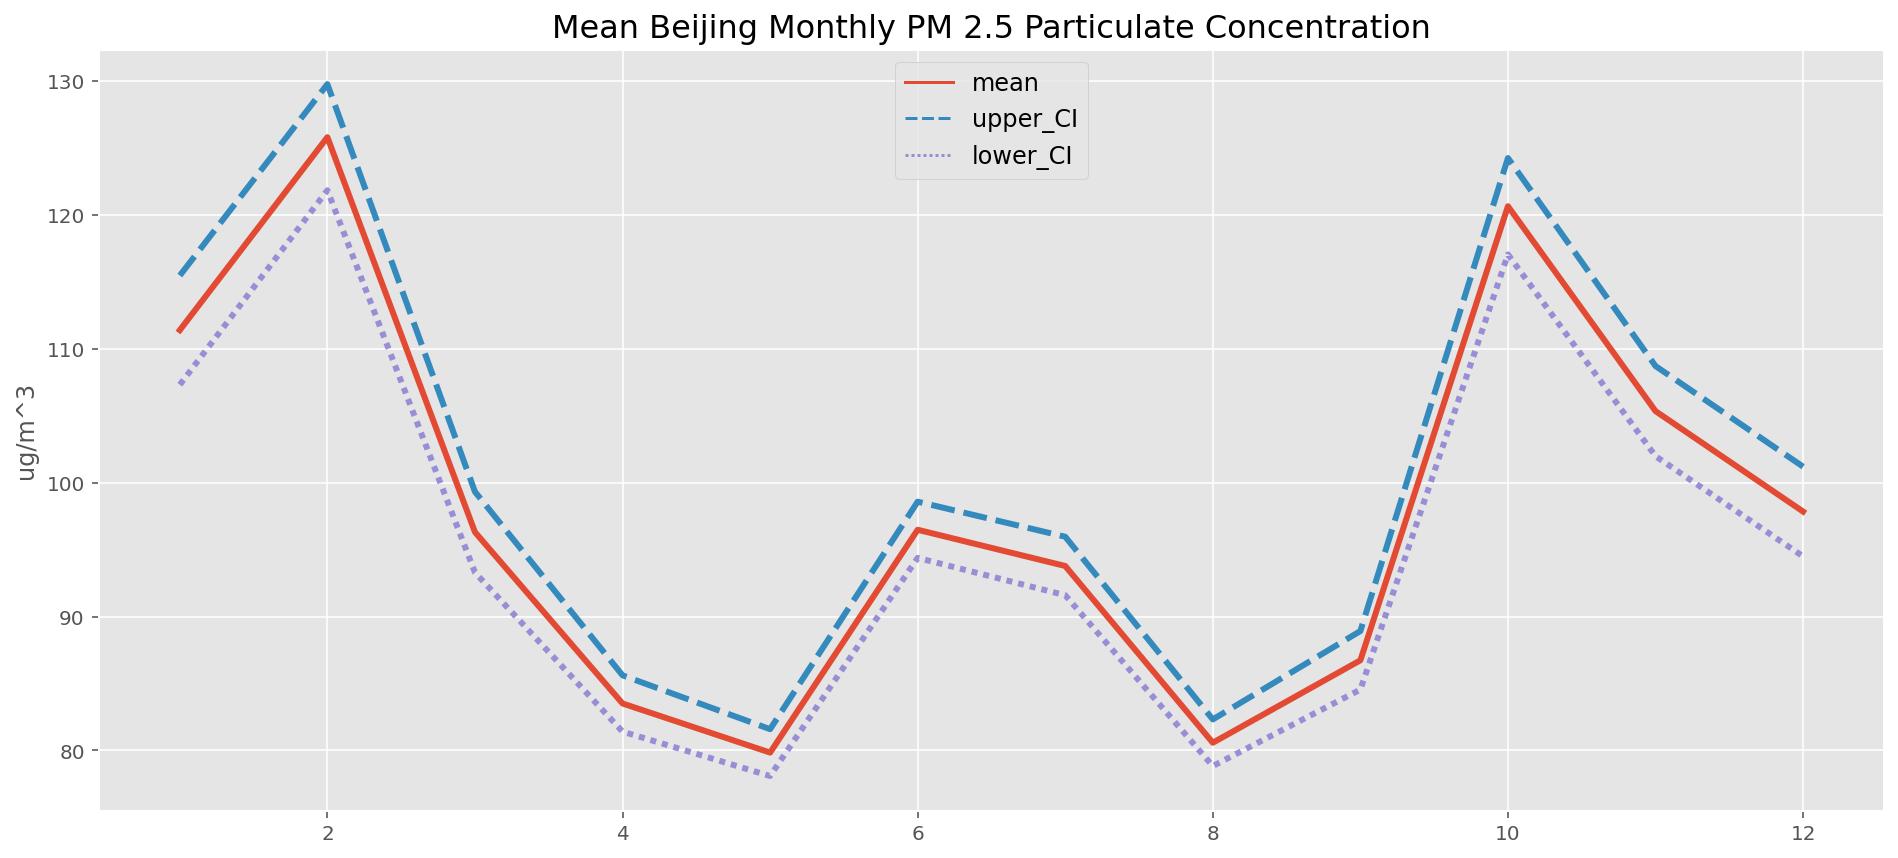

In [56]:
month_avg = seasonal_mean(df, 'month', 'pm25')

fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=month_avg, ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Mean Beijing Monthly PM 2.5 Particulate Concentration', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

# Stationarity Tests

In [57]:
adf_statistics(df.pm25)

ADF Statistic: -21.3684
p-value: 0.0000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
Null hypothesis of non-stationarity is rejected


In [58]:
adf_statistics(df.temp)

ADF Statistic: -3.9383
p-value: 0.0018
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
Null hypothesis of non-stationarity is rejected


In [59]:
adf_statistics(df.dewp)

ADF Statistic: -6.1229
p-value: 0.0000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
Null hypothesis of non-stationarity is rejected


# Data Engineering

### Create one period-ahead target & date variables

In [60]:
# Generate the target variable
df['target'] = df['pm25'].shift(-1)

Create a **weekend dummy**

In [61]:
df['wkend'] = (df.index.weekday >= 5).astype(int)

Create **contemporaneous time/seasonal** variables that are **concurrent** with the target variable. Time is **deterministic**, e.g. 9pm will follow 8pm and May will follow April, so the time variables may be set concurrent with the one-period target.

In [62]:
df['cmonth'] = df['month'].shift(-1)
df['chour'] = df['hour'].shift(-1)
df['cwkend'] = df['wkend'].shift(-1)

In [63]:
df = df[~df['target'].isnull()]

### One-Hot Encode 'cbwd' (wind direction)

In [64]:
df['cbwd'] = df.cbwd.factorize()[0]

In [65]:
df = pd.get_dummies(df, columns=['cbwd'], drop_first=True)

### Miscellaneous

In [66]:
df = df[~df['target'].isnull()]

In [67]:
# Dropping unnecessary and redundant variables...
df.drop(['year', 'month', 'day', 'hour', 'number', 'cr', 'cs', 'pres', 'wkend', 'pm25_scaled'], axis=1, inplace=True)

In [68]:
df['date'] = df.index

### Create cyclic time variables

In [69]:
df['mth_sin'], df['mth_cos'] = cyclic_transform(df.cmonth)

In [70]:
df['hour_sin'], df['hour_cos'] = cyclic_transform(df.chour)

### Create dummies from month & hour categorical variables

In [71]:
# First generate hour and month numeric variables
df['hour_num'] = df['chour']
df['mth_num'] = df['cmonth']

In [72]:
# Transform the contemporaneous month and hour categorical variables into dummies
df = pd.get_dummies(df, columns=['cmonth', 'chour'], drop_first=True)

In [73]:
df[['hour_num', 'chour_2.0', 'chour_20.0', 'chour_22.0']]

,hour_num,chour_2.0,chour_20.0,chour_22.0
date,,,,
2010-01-02 00:00:00,1.0,0,0,0
2010-01-02 01:00:00,2.0,1,0,0
2010-01-02 02:00:00,3.0,0,0,0
2010-01-02 03:00:00,4.0,0,0,0
2010-01-02 04:00:00,5.0,0,0,0
...,...,...,...,...
2014-12-31 18:00:00,19.0,0,0,0
2014-12-31 19:00:00,20.0,0,1,0
2014-12-31 20:00:00,21.0,0,0,0


In [74]:
df.isnull().values.any()

False

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43799 entries, 2010-01-02 00:00:00 to 2014-12-31 22:00:00
Data columns (total 50 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   pm25         43799 non-null  int64         
 1   dewp         43799 non-null  int64         
 2   temp         43799 non-null  int64         
 3   cws          43799 non-null  float64       
 4   target       43799 non-null  float64       
 5   cwkend       43799 non-null  float64       
 6   cbwd_1       43799 non-null  uint8         
 7   cbwd_2       43799 non-null  uint8         
 8   cbwd_3       43799 non-null  uint8         
 9   date         43799 non-null  datetime64[ns]
 10  mth_sin      43799 non-null  float64       
 11  mth_cos      43799 non-null  float64       
 12  hour_sin     43799 non-null  float64       
 13  hour_cos     43799 non-null  float64       
 14  hour_num     43799 non-null  float64       
 15  mth_num      43799

In [76]:
# Saving engineered dataset
#df.to_csv(r'C:\\beijing_engineered.csv', index=False)